# Xarxa neuronal

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform as sp_rand
from scipy.stats import randint
from time import time
from sklearn import preprocessing

Using TensorFlow backend.


## Consum diari total multivariate one-step

In [2]:
daily=pd.read_csv('C:/Users/Laura/Desktop/Smart meters London/workspace R/Dades netes/Final/daily_agr_mitjanaLlarPerDia.csv')
daily.head(5)

,date,apparentTemperatureMax,sunsetTimeHour,weekday,season,cloudCover,humidity,visibility,month,energy_sum
0,2013-01-16,-0.15,16,3,winter,0.48,0.91,4.12,1,13.147536
1,2013-01-20,-0.46,16,7,winter,0.85,0.91,5.10,1,15.021900
2,2013-01-10,2.36,16,4,winter,0.70,0.94,5.21,1,12.066789
3,2013-01-06,6.98,16,7,winter,0.67,0.96,5.50,1,12.422263
4,2012-01-31,1.13,16,2,winter,0.55,0.84,5.62,1,13.890518


In [3]:
#Ens quedem amb date i energy_sum, ordenem valors per data i resetejem index
daily_dia=daily[['date','energy_sum','apparentTemperatureMax']].sort_values(by=['date']).reset_index()
daily_dia.head(5)


,index,date,energy_sum,apparentTemperatureMax
0,677,2011-11-23,6.952692,10.36
1,691,2011-11-24,8.536480,12.93
2,713,2011-11-25,9.499781,13.03
3,728,2011-11-26,10.267707,12.96
4,729,2011-11-27,10.850805,13.54


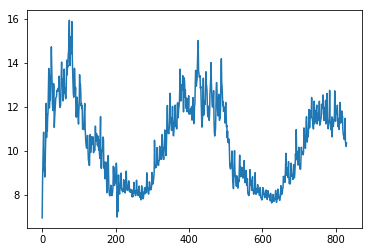

In [16]:
plt.plot(daily_dia )

In [4]:
daily_dia['t-1']=daily_dia['energy_sum'].shift(1)
daily_dia['t-2']=daily_dia['energy_sum'].shift(2)
daily_dia['t-3']=daily_dia['energy_sum'].shift(3)
daily_dia['t-4']=daily_dia['energy_sum'].shift(4)
daily_dia['t-5']=daily_dia['energy_sum'].shift(5)
daily_dia['t-6']=daily_dia['energy_sum'].shift(6)
daily_dia['t-7']=daily_dia['energy_sum'].shift(7)
daily_dia['t-8']=daily_dia['energy_sum'].shift(8)

daily_dia['temp(t-1)']=daily_dia['apparentTemperatureMax'].shift(1)
daily_dia['temp(t-2)']=daily_dia['apparentTemperatureMax'].shift(2)
daily_dia['temp(t-3)']=daily_dia['apparentTemperatureMax'].shift(3)
daily_dia['temp(t-4)']=daily_dia['apparentTemperatureMax'].shift(4)
daily_dia['temp(t-5)']=daily_dia['apparentTemperatureMax'].shift(5)
daily_dia['temp(t-6)']=daily_dia['apparentTemperatureMax'].shift(6)
daily_dia['temp(t-7)']=daily_dia['apparentTemperatureMax'].shift(7)
daily_dia['temp(t-8)']=daily_dia['apparentTemperatureMax'].shift(8)


daily_dia

,index,date,energy_sum,apparentTemperatureMax,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,temp(t-1),temp(t-2),temp(t-3),temp(t-4),temp(t-5),temp(t-6),temp(t-7),temp(t-8)
0,677,2011-11-23,6.952692,10.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,691,2011-11-24,8.536480,12.93,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,713,2011-11-25,9.499781,13.03,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,12.93,10.36,NaN,NaN,NaN,NaN,NaN,NaN
3,728,2011-11-26,10.267707,12.96,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,13.03,12.93,10.36,NaN,NaN,NaN,NaN,NaN
4,729,2011-11-27,10.850805,13.54,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,12.96,13.03,12.93,10.36,NaN,NaN,NaN,NaN
5,704,2011-11-28,9.103382,12.58,10.850805,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN,13.54,12.96,13.03,12.93,10.36,NaN,NaN,NaN
6,718,2011-11-29,9.274873,13.47,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692,NaN,NaN,12.58,13.54,12.96,13.03,12.93,10.36,NaN,NaN
7,727,2011-11-30,8.813513,11.87,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692,NaN,13.47,12.58,13.54,12.96,13.03,12.93,10.36,NaN
8,778,2011-12-01,9.227707,12.15,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692,11.87,13.47,12.58,13.54,12.96,13.03,12.93,10.36
9,773,2011-12-02,10.145910,5.33,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,12.15,11.87,13.47,12.58,13.54,12.96,13.03,12.93


In [5]:
#Ens quedem amb energies i temperatures 
#No agafem apparent temperature max ja que quan fem la predicció representa que no ho sabem
daily_dia=daily_dia[['energy_sum','t-1','t-2','t-3','t-4','t-5','t-6','t-7','t-8','temp(t-1)','temp(t-2)','temp(t-3)','temp(t-4)','temp(t-5)','temp(t-6)','temp(t-7)','temp(t-8)']]
daily_dia.head(5)


,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,temp(t-1),temp(t-2),temp(t-3),temp(t-4),temp(t-5),temp(t-6),temp(t-7),temp(t-8)
0,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,12.93,10.36,NaN,NaN,NaN,NaN,NaN,NaN
3,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,13.03,12.93,10.36,NaN,NaN,NaN,NaN,NaN
4,10.850805,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,12.96,13.03,12.93,10.36,NaN,NaN,NaN,NaN


In [6]:
#Eliminem les 8 primeres files ja que contenen NaN (valors buits)

daily_dia=daily_dia.drop([0,1,2,3,4,5,6,7])
daily_dia.head(5)

,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,temp(t-1),temp(t-2),temp(t-3),temp(t-4),temp(t-5),temp(t-6),temp(t-7),temp(t-8)
8,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692,11.87,13.47,12.58,13.54,12.96,13.03,12.93,10.36
9,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,12.15,11.87,13.47,12.58,13.54,12.96,13.03,12.93
10,10.780273,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,5.33,12.15,11.87,13.47,12.58,13.54,12.96,13.03
11,12.163127,10.780273,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,11.42,5.33,12.15,11.87,13.47,12.58,13.54,12.96
12,10.609714,12.163127,10.780273,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805,6.66,11.42,5.33,12.15,11.87,13.47,12.58,13.54


In [7]:
len(daily_dia)


822

In [8]:

#normalitzem
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
daily_dia_norm=scaler.fit_transform(daily_dia)

#daily_dia_norm[:,0]
print(daily_dia_norm)
#daily_dia_norm[:,1:]


[[0.250036   0.20375985 0.25530572 ... 0.46920339 0.46646592 0.39611278]
 [0.35262316 0.250036   0.20375985 ... 0.46728716 0.46920339 0.46646592]
 [0.42349794 0.35262316 0.250036   ... 0.48316452 0.46728716 0.46920339]
 ...
 [0.36928    0.38228562 0.50172153 ... 0.38981659 0.38981659 0.40459896]
 [0.35899548 0.36928    0.38228562 ... 0.45469477 0.38981659 0.38981659]
 [0.37613476 0.35899548 0.36928    ... 0.39036408 0.45469477 0.38981659]]


In [47]:
X_daily[0]

array([0.25530572, 0.2361457 , 0.43137821, 0.36623108, 0.28043381,
       0.17280805, 0.        , 0.48124829, 0.45688475, 0.48316452,
       0.46728716, 0.46920339, 0.46646592, 0.39611278])

In [9]:


#Seleccionem dades per test i train
y_daily=daily_dia_norm[:,0]
X_daily=daily_dia_norm[:,1:17]

#y_daily=daily_dia['energy_sum']
#X_daily=daily_dia.drop(['energy_sum'], axis='columns')



#Reshape de [samples,timesteps] a [samples,timesteps,features]

#Enlloc de 14 features en son 7 de una feature i 7 duna altre
X_daily=np.reshape(X_daily, (X_daily.shape[0], 8,2))


In [10]:
# definim model
import tensorflow as tf
model =Sequential()
model.add(LSTM(50, activation='relu', input_shape=(8, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [11]:

import math
from sklearn.metrics import mean_squared_error

#Walk forward per test i train
minim=100
n_train=465
lenght=len(daily_dia)

llista_evaluate=list()
llista_prediccions=list()
llista_preditrain=list()
llista_scores=list()
llista_scoretrain=list()
sumScores=0

for i in range(n_train,lenght):
    minim=minim+1
    X_train,X_test= X_daily[minim:i],X_daily[i:i+1]
    y_train,y_test= y_daily[minim:i],y_daily[i:i+1]

    #fem fit al model
    model.fit(X_train, y_train, epochs=50, verbose=0)
    
    #mostrem score per cada model
    score=model.evaluate(X_test,y_test,verbose=0)
    llista_evaluate.append(score)
    
    #Predim per cadascun
    preditest=model.predict(X_test)
    llista_prediccions.append(preditest)
    
    preditrain=model.predict(X_train)
    llista_preditrain.append(preditrain)
    
    trainScore = math.sqrt(mean_squared_error(y_train, preditrain))
    llista_scoretrain.append(trainScore )
    

    testScore = math.sqrt(mean_squared_error(y_test, preditest))
    llista_scores.append(testScore)
   
    sumScores=sumScores+testScore

Instructions for updating:
Use tf.cast instead.


In [53]:
#Dividim la suma de scores de test entre el nombre de prediccions per obtenir la mitjana
sumScores/(lenght-n_train)

0.036842092976021465

In [66]:
sumScores/len(listpredi)

0.036842092976021465

In [68]:
print(model.metrics_names)

['loss', 'acc']


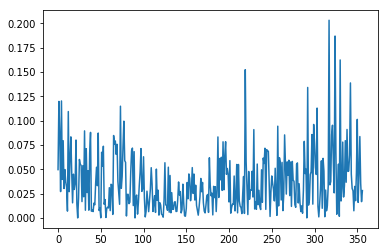

In [59]:
plt.plot(llista_scores)

In [14]:
predis=list()

for i in range(len(llista_prediccions)):
    predi=llista_prediccions[i].tolist()
    predis.append(predi)

predis=np.reshape(predis, (357)  )

predis

array([0.46085009, 0.53195691, 0.59825253, 0.68217349, 0.69342124,
       0.57553029, 0.5935061 , 0.55025238, 0.57454509, 0.57619506,
       0.45969853, 0.5292812 , 0.61381954, 0.59481907, 0.65893263,
       0.72126961, 0.73082519, 0.64654744, 0.66026759, 0.59480816,
       0.62077057, 0.61666107, 0.53775054, 0.55210423, 0.53695619,
       0.53798634, 0.49620968, 0.63660848, 0.54668939, 0.51269543,
       0.44384259, 0.4921385 , 0.44494465, 0.45125276, 0.4250561 ,
       0.42657471, 0.3875967 , 0.40787923, 0.34827465, 0.24323215,
       0.25302354, 0.24590921, 0.29008964, 0.29254162, 0.30004275,
       0.32274878, 0.22045609, 0.25671917, 0.13658869, 0.18956566,
       0.28308117, 0.26986459, 0.28494608, 0.28095829, 0.18739031,
       0.15616195, 0.15610532, 0.20004138, 0.21367544, 0.17459342,
       0.17834769, 0.16153166, 0.22600067, 0.21356571, 0.25172818,
       0.23015893, 0.27986604, 0.17786652, 0.18779933, 0.28232181,
       0.21208081, 0.21485993, 0.23658533, 0.11186726, 0.22881

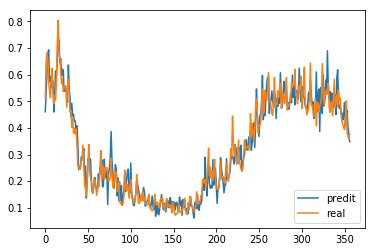

In [15]:
##Mostrem
plt.plot(predis, label="predit")
plt.plot(y_daily[n_train:lenght], label="real")
plt.legend(loc="lower right")
plt.show()

In [54]:
#Creem un dataset amb format (nombre prediccions,17) per tornar les prediccions i els valors y als reals sense normalitzar
#El necessitem d'questa mida encara que només volguem passar 2 variables ja que al fer el minmax amb 17 variables
#per fer la inversa necessitem 17 variables
#Com que només en tenim 2, les ajuntem al dataset inicial i ens quedem amb 15 variables aleatories mes
#Obtenint un dataset amb 15 variables aleatories i les 2 variables que ens interessen (predi i y)

prova=daily_dia.iloc[n_train:lenght]
prova
#len(predis)
#lenght-n_train
prova['predi']=predis
prova['y']=y_daily[n_train:lenght]
prova=prova.drop(['energy_sum','t-1'], axis=1)
prova

prova=prova[['predi','y','t-2','t-3','t-4','t-5','t-6','t-7','t-8','temp(t-1)','temp(t-2)','temp(t-3)','temp(t-4)','temp(t-5)','temp(t-6)','temp(t-7)','temp(t-8)']]
prova

c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,predi,y,t-2,t-3,t-4,t-5,t-6,t-7,t-8,temp(t-1),temp(t-2),temp(t-3),temp(t-4),temp(t-5),temp(t-6),temp(t-7),temp(t-8)
473,0.460850,0.510600,10.889469,10.675248,10.860481,11.481859,12.735907,12.308851,12.048499,9.04,7.99,13.14,16.06,6.17,5.04,3.13,3.28
474,0.531957,0.651732,10.930170,10.889469,10.675248,10.860481,11.481859,12.735907,12.308851,7.53,9.04,7.99,13.14,16.06,6.17,5.04,3.13
475,0.598253,0.683428,11.559878,10.930170,10.889469,10.675248,10.860481,11.481859,12.735907,0.33,7.53,9.04,7.99,13.14,16.06,6.17,5.04
476,0.682173,0.654997,12.823073,11.559878,10.930170,10.889469,10.675248,10.860481,11.481859,-4.11,0.33,7.53,9.04,7.99,13.14,16.06,6.17
477,0.693421,0.573173,13.106773,12.823073,11.559878,10.930170,10.889469,10.675248,10.860481,-0.56,-4.11,0.33,7.53,9.04,7.99,13.14,16.06
478,0.575530,0.535873,12.852295,13.106773,12.823073,11.559878,10.930170,10.889469,10.675248,3.01,-0.56,-4.11,0.33,7.53,9.04,7.99,13.14
479,0.593506,0.514061,12.119938,12.852295,13.106773,12.823073,11.559878,10.930170,10.889469,5.17,3.01,-0.56,-4.11,0.33,7.53,9.04,7.99
480,0.550252,0.580609,11.786082,12.119938,12.852295,13.106773,12.823073,11.559878,10.930170,4.56,5.17,3.01,-0.56,-4.11,0.33,7.53,9.04
481,0.574545,0.624326,11.590859,11.786082,12.119938,12.852295,13.106773,12.823073,11.559878,3.91,4.56,5.17,3.01,-0.56,-4.11,0.33,7.53
482,0.576195,0.539280,12.186487,11.590859,11.786082,12.119938,12.852295,13.106773,12.823073,5.13,3.91,4.56,5.17,3.01,-0.56,-4.11,0.33


In [55]:
# Convert predictions back to normal values

predi = scaler.inverse_transform(prova)
print(predi[0][0])
print(predi[0][1])

#Les variables en posició 15 i 16 són predicció i y respectivament

11.114592110340794
11.559878061079399


In [57]:
#Fem una llista amb les prediccions i una llista amb y(valor real)

listpredi=list()
for i in range(len(predi)):
    listpredi.append(predi[i][0])
listpredi

listy=list()
for i in range(len(predi)):
    listy.append(predi[i][1])
listy

[11.559878061079399,
 12.8230727297735,
 13.1067729697477,
 12.852295264929099,
 12.119938075341,
 11.786081673764802,
 11.590859170709699,
 12.186486909458,
 12.5777825527296,
 11.816572589134799,
 11.3876267050719,
 11.6632140210701,
 11.5047561338867,
 12.071172692490801,
 13.4292708131623,
 14.1915913964734,
 13.1182948122023,
 12.916559451200099,
 12.4960441531868,
 12.050954318124699,
 12.231575736212301,
 11.7919036962847,
 11.9327208888355,
 11.9327208888355,
 11.9824229419611,
 11.266251710893302,
 11.923225859637402,
 12.2019722473821,
 11.7314792668086,
 11.097177003906697,
 11.158295184648098,
 10.593420449120199,
 10.900387923175302,
 10.391371941845799,
 10.5597506942169,
 10.3722930491566,
 10.531617352131999,
 10.0442564420545,
 9.3196743918969,
 9.22987664514932,
 9.17927174876646,
 9.25026850964928,
 9.44901226100687,
 9.48570009257196,
 9.99667631842984,
 9.411523304475391,
 8.66526337323551,
 8.506098960360191,
 8.28206681505197,
 8.77842514832838,
 9.52584724036424

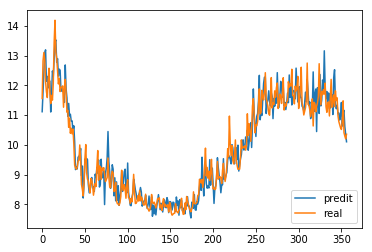

In [58]:
##Mostrem
plt.plot(listpredi, label="predit")
plt.plot(listy, label="real")
plt.legend(loc="lower right")
plt.show()

In [60]:
listy[1]

12.8230727297735

In [62]:
llista_errors=list()
llista_errorsabs=list()
llista_errorsres=list()

    
for i in range(len(listpredi)):
    valor=listy[i]-listpredi[i]
    valorabs=math.fabs(valor)
    valorrespecte=valorabs/listy[i]
    llista_errors.append(valor)
    llista_errorsabs.append(valorabs)
    llista_errorsres.append(valorrespecte)




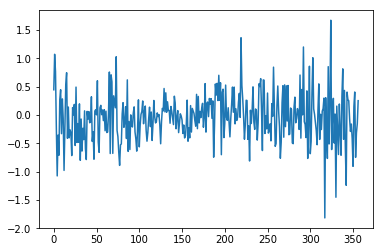

In [63]:
plt.plot(llista_errors)

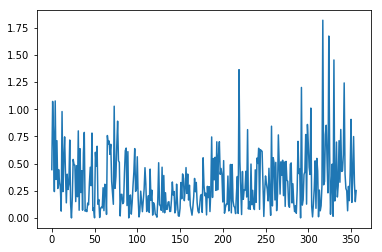

In [64]:
plt.plot(llista_errorsabs)

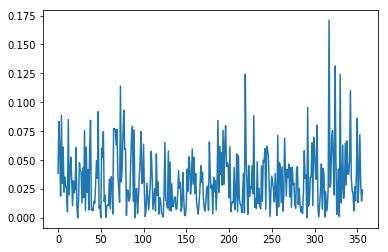

In [69]:
plt.plot(llista_errorsres)

In [70]:
sum(llista_errorsres)/(len(llista_errorsres))

0.0327493809766566